# Qiskit Runtime - Estimator Primitive and Sessions

## Primitives

Primitives are a set of interface with Qiskit Runtime to help users build complex algorithms based on the results they need.

The existing Qiskit interface to backends `backend.run()` was originally designed to accept a list of circuits and return counts for every job. However the raw results might not be useful for users, hence the need for primitives. They provide methods that make it easier to build modular algorithms and other higher-order programs. Rather than simply returning counts, they return more immediately meaningful information. Additionally, they provide a seamless way to access the latest optimizations in IBM Quantum hardware and software.

Two primitives are available :

- **Estimator** : 
    - Allows a user to specify a list of circuits and observables and selectively group between the lists to efficiently evaluate expectation values and variances for a parameter input. It is designed to enable users to efficiently calculate and interpret expectation values of quantum operators that are required for many algorithms. 
- **Sampler** :
    - Allows a user to input a circuit and then generate quasiprobabilities. This generation enables users to more efficiently evaluate the possibility of multiple relevant data points in the context of destructive interference.

In the following notebook we'll see how to use the primitives with Qiskit Runtime, and all the different options available for the run.

## How to use the primitives

### 1. Choose which primitive to use

As you can see on the [guide](https://qiskit.org/ecosystem/ibm-runtime/migrate/migrate-guide.html), you have different primitives implementations based on what you need.

- The primitives in `qiskit` can perform local state vector simulations - useful for quickly prototyping algorithms.
- The primitives in `qiskit_aer` give access to the local Aer simulators for tasks such as noisy simulation.
- The primitives in `qiskit_ibm_runtime` provide access to cloud simulators and real hardware through the Qiskit Runtime service. They include exclusive features such as built-in circuit optimization and error mitigation support.


Here we'll mainly focus on the Qiskit Runtime primitives. Note that they are the only ones that give you access to the Qiskit Runtime service.

You also have to choose from either the `Estimator` or the `Sampler`.
- If it uses an expectation value, you will need an `Estimator`.
- If it uses a probability distribution (from sampling the device), you will need a `Sampler`.



### 2. Initialize your account


In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

instance = 'ibm-q/open/main'
service = QiskitRuntimeService(channel='ibm_quantum', instance = instance)

### 3. Load the backend

You can pass either one or the other when running the program, both will work.

In [2]:
sim_name='ibmq_qasm_simulator'
sim = service.backend(sim_name)

### 4. Create your circuit and observable

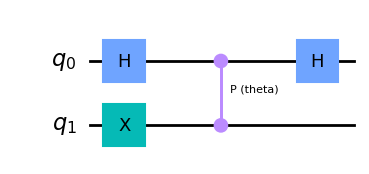

In [3]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

theta = Parameter('theta')

qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta,0,1)
qc.h(0)

qc.draw('mpl')

In [4]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp("ZZ")
print(f"Observable: {observable.paulis}")

Observable: ['ZZ']


### 5. Load the primitives

In [5]:
from qiskit_ibm_runtime import Estimator, Options

options = Options(max_execution_time = 300)
estimator = Estimator(backend = sim, options = options)

### 6. Invoke the primitive and get back results

In [6]:
qc_bound = qc.bind_parameters({theta: 2})
job_est = estimator.run(qc_bound, observable)
result = job_est.result()

print(result)
print(f"Expectation value: {result.values[0]}")
print(f"Metadata: {result.metadata[0]}")

EstimatorResult(values=array([0.4275]), metadata=[{'variance': 0.81724375, 'shots': 4000}])
Expectation value: 0.4275
Metadata: {'variance': 0.81724375, 'shots': 4000}



## Sessions


A session is a contract between the user and the Qiskit Runtime service, making sure that a collection of jobs can be grouped and jointly prioritized by the quantum computer’s job scheduler. Jobs submitted within the session are not interrupted by other users’ jobs.

Sessions offer quite an advantage for algorithms needing iterative calls between classical and quantum, so that you don't lose time waiting in the queue at each step.



### Benefits of a session call

- Jobs that belong to a single algorithm run are run together without interruption, increasing efficiency if your program submits multiple sequential jobs.
    - The queuing time does not decrease for the first job submitted within a session. Therefore, a session does not provide any benefits if you only need to run a single job.
    - Since data from the first session job is cached and used by subsequent jobs, if the first job is cancelled, subsequent session jobs will all fail.
- When using sessions, the uncertainty around queuing time is significantly reduced. This allows better estimation of a workload’s total runtime and better resource management.
- In a device characterization context, being able to run experiments closely together helps prevent device drifts and provide more accurate results.
- As long as the session is active, you can submit different jobs, inspect job results, and re-submit new jobs without opening a new session.
- You maintain the flexibility to deploy your programs either remotely (cloud / on-premise) or locally (your laptop).

### The mechanics of a session

For each backend, the first job in the session waits its turn in the queue normally, but while the session is active, subsequent jobs within the same session take priority over any other queued jobs. If no jobs that are part of the active session are ready, the session is deactivated (paused), and the next job from the regular fair-share queue is run.


#### Iterative execution

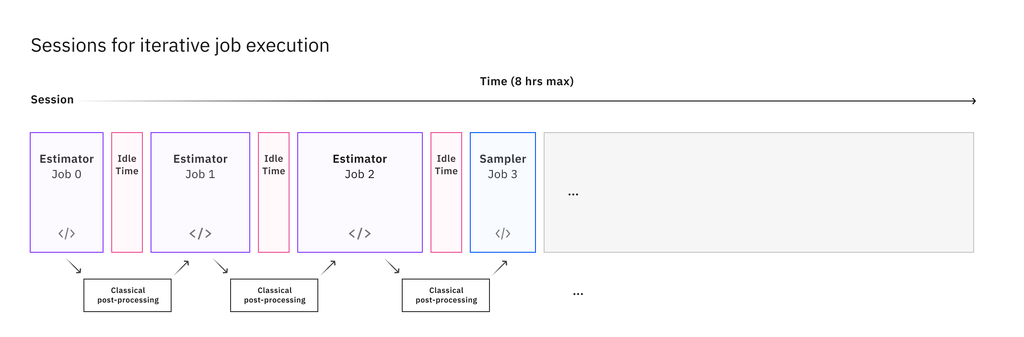

#### Batch execution

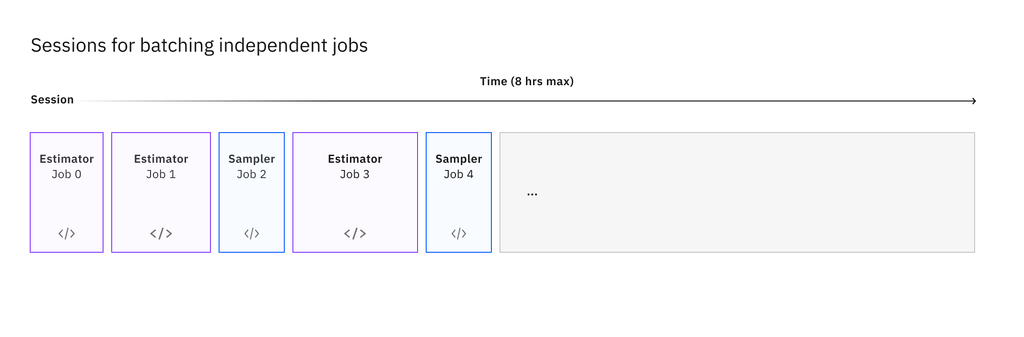

### Session Timing

When a session is started, it is assigned a maximum session timeout value. You can set this value by using the max_time parameter.

If you don’t specify a timeout value, it is the smaller of these values:

- The system limit.
- The max_execution_time defined by the program.

After this time limit is reached, the session is permanently closed.

A session also has an interactive timeout value of 5 minutes. If there are no session jobs queued within that window, the session is temporarily deactivated and normal job selection resumes. This interactive timeout value is set by the system and cannot be overwritten.  
As long as the max time out of the session is not reached, the session can still be reactivated, but the next job will have to go through the queue like any job.

## Options

The [Options](https://qiskit.org/ecosystem/ibm-runtime/stubs/qiskit_ibm_runtime.options.Options.html) class allows you to specify several parameters in the primitives. The two most commonly used ones are
- [optimization_level](https://qiskit.org/ecosystem/ibm-runtime/how_to/error-suppression.html) : for error suppression, it is the level of transpilation you wish to apply to your circuit. It is classical pre-processing to your overall runtime.
- [resilience_level](https://qiskit.org/ecosystem/ibm-runtime/how_to/error-mitigation.html) : for error mitigation, it allows mitigation of circuit errors by modeling the device noise at the time of execution. It results in quantum pre-processing overhead related to model training and classical post-processing overhead to mitigate errors in the raw results by using the generated model.

Depending on which primitive you use, techniques might be different. The `optimization_level` will be the exact same for both. As for the `resilience_level`, techniques and levels will vary between the two.

- Sampler
    - `optimization_level` : 0 to 3, default to 3
    - `resilience_level` : 0 to 1, default to 1

- Estimator
    - `optimization_level` : 0 to 3, default to 3
    - `resilience_level` : 0 to 3, default to 1




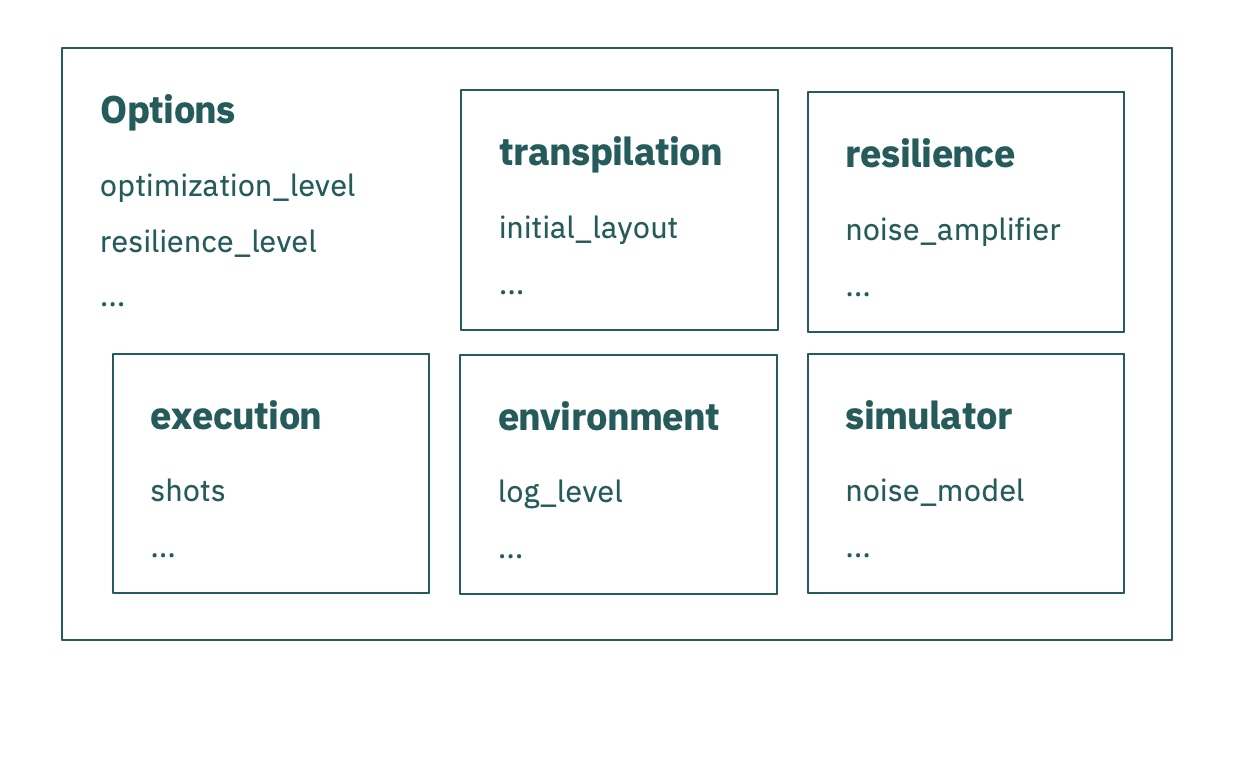

### A little more about error mitigation

[Error mitigation configuration tutorial.](https://qiskit.org/ecosystem/ibm-runtime/how_to/error-mitigation.html)

| Resilience level | Definition | Estimator | Sampler |
|--|--|--|--|
| 0 | No mitigation | None | None |
|1 (Default) | Minimal mitigation costs: Mitigate error associated with readout errors | Twirled Readout Error eXtinction (TREX) | M3|
|2 | Medium mitigation costs. Typically reduces bias in estimators, but is not guaranteed to be zero bias. | Zero Noise Extrapolation (ZNE) | — |
|3 | Heavy mitigation with layer sampling. Theoretically expected to deliver zero bias estimators. | Probabilistic Error Cancellation (PEC) | — |


- T-REx: [arXiv:2012.09738](https://arxiv.org/abs/2012.09738)
- ZNE: [arXiv:1612.02058](https://arxiv.org/abs/1612.02058)
- PEC: [arXiv:1612.02058](https://arxiv.org/abs/1612.02058)

#### Resilience level 0

No mitigation is applied at all when using the level 0.

#### Resilience level 1

- **Sampler** : Level 1 uses matrix-free measurement mitigation (M3) routine to mitigate readout error. M3 works in a reduced subspace defined by the noisy input bit strings that are to be corrected. Because the number of unique bit strings can be much smaller than the dimensionality of the full multi-qubit Hilbert space, the resulting linear system of equations is nominally much easier to solve.



- **Estimator** : Level 1 applies error mitigation methods that particularly address readout errors. In the Estimator, we apply a model-free technique known as Twirled Readout Error eXtinction (TREX). It reduces measurement error by diagonalizing the noise channel associated with measurement by randomly flipping qubits through X gates immediately before measurement, and flipping the corresponding measured bit if an X gate was applied. A rescaling term from the diagonal noise channel is learned by benchmarking random circuits initialized in the zero state. This allows the service to remove bias from expectation values that result from readout noise.


#### Resilience level 2

Level 2 uses the Zero Noise Extrapolation method (ZNE) which computes an expectation value of the observable for different noise factors (amplification stage) and then uses the measured expectation values to infer the ideal expectation value at the zero-noise limit (extrapolation stage). This approach tends to reduce errors in expectation values, but is not guaranteed to produce an unbiased result.

The overhead of this method scales with the number of noise factors. The default settings sample the expectation value at three noise factors, leading to a roughly 3x overhead when employing this resilience level.



#### Resilience level 3

Level 3 enables the Probabilistic Error Cancellation (PEC) method. This approach mitigates error by learning and inverting a sparse noise model that is able to capture correlated noise. PEC returns an unbiased estimate of an expectation value so long as learned noise model faithfully represents the actual noise model at the time of mitigation. In practice, the experimental procedure for learning the noise model has ambiguities due to certain error terms that cannot be independently distinguished. These are resolved by a symmetry assumption, which depending on the true underlying noise may lead a biased estimate of the mitigated expectation values due to using an imperfect noise model.



### Noisy simulation

Let's try to do a noisy simulation : 


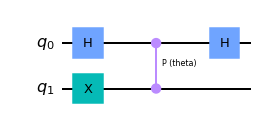

In [7]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

theta = Parameter('theta')

qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta,0,1)
qc.h(0)

qc.draw('mpl')

In [8]:
import numpy as np

phases = np.linspace(0, 2*np.pi, 50)

# phases need to be expressed as a list of lists in order to work
individual_phases = [[phase] for phase in phases]
print(individual_phases)

[[0.0], [0.1282282715750936], [0.2564565431501872], [0.38468481472528077], [0.5129130863003744], [0.6411413578754679], [0.7693696294505615], [0.8975979010256552], [1.0258261726007487], [1.1540544441758422], [1.2822827157509358], [1.4105109873260295], [1.538739258901123], [1.6669675304762166], [1.7951958020513104], [1.9234240736264039], [2.0516523452014974], [2.179880616776591], [2.3081088883516845], [2.436337159926778], [2.5645654315018716], [2.6927937030769655], [2.821021974652059], [2.9492502462271526], [3.077478517802246], [3.2057067893773397], [3.333935060952433], [3.4621633325275267], [3.5903916041026207], [3.7186198756777142], [3.8468481472528078], [3.9750764188279013], [4.103304690402995], [4.231532961978089], [4.359761233553182], [4.487989505128276], [4.616217776703369], [4.744446048278463], [4.872674319853556], [5.00090259142865], [5.129130863003743], [5.257359134578837], [5.385587406153931], [5.513815677729024], [5.642043949304118], [5.770272220879211], [5.898500492454305], [

In [9]:
from qiskit.quantum_info import SparsePauliOp

ZZ = SparsePauliOp.from_list([("ZZ", 1)])
ZZ.to_matrix()

array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]])

Here we won't do any error mitigation : 

In [10]:
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

# Make a noise model
fake_backend = FakeManila()

noise_model = NoiseModel.from_backend(fake_backend)
basis_gates = fake_backend.configuration().basis_gates
coupling_map = fake_backend.configuration().coupling_map


# Set options to include the noise model
options = Options()
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": basis_gates,
    "coupling_map": coupling_map,
    "seed_simulator": 42
}

# Set number of shots, optimization_level and resilience_level
options.execution.shots = 1000
options.optimization_level = 0
options.resilience_level = 0


And another option with error mitigation : 

In [11]:
# Set options to include the noise model with error mitigation
options_with_em = Options()
options_with_em.simulator = {
    "noise_model": noise_model,
    "basis_gates": basis_gates,
    "coupling_map": coupling_map,
    "seed_simulator": 42
}

# Set number of shots, optimization_level and resilience_level
options_with_em.execution.shots = 1000
options_with_em.optimization_level = 0 # no optimization
options_with_em.resilience_level = 1 # M3 for Sampler and T-REx for Estimator


In [12]:
from qiskit_ibm_runtime import Session


with Session(service = service, backend = sim) as session:
    # include the noise model without T-REx
    estimator = Estimator(options = options, session = session)
    job = estimator.run(
        circuits = [qc]*len(phases),
        parameter_values = individual_phases,
        observables = [ZZ]*len(phases)
    )
    result = job.result()
    exp_values = result.values

    # include the noise model with T-REx
    estimator = Estimator(options = options_with_em, session = session)
    job = estimator.run(
        circuits = [qc]*len(phases),
        parameter_values = individual_phases,
        observables = [ZZ]*len(phases))
    result = job.result()
    exp_values_with_em = result.values
    session.close()

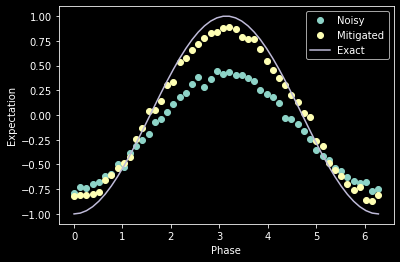

In [14]:
import matplotlib.pyplot as plt

plt.plot(phases, exp_values, 'o', label='Noisy')
plt.plot(phases, exp_values_with_em, 'o', label='Mitigated')
plt.plot(phases, 2*np.sin(phases/2)**2-1, label='Exact')
plt.xlabel('Phase')
plt.ylabel('Expectation')
plt.legend()